# Finetuning de modelos BERT para classificação de laudos médicos

## O que é o BERT

Bidirectional Encoder Representations from Transformers ou BERT é um Large Language Model (LLM) desenvolvido pela Google AI Language e publicado como [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding (Devlin et al., 2018)](https://arxiv.org/abs/1810.04805).

O modelo original foi lançado logo após o lançamento público do primeiro membro da familia Generative Pre-trained Transformer (GPT) pela Open AI publicado como [Improving Language Understanding by Generative Pre-Training (Radfors et al., 2018)](https://openai.com/index/language-unsupervised/)

As duas implementações são baseadas na arquitetura Transformer, introduzida em [Attention Is All You Need (Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762)

<mark>Enquanto modelos LLM GPT focam em Natural Language Generation (NLG), modelos LLM BERT são voltados a Natural Language Understanding (NLU).</mark>

Ambas as arquiteturas **decoder-only** do GPT e **encoder-only** do BERT são capazes de produzir modelos formidáveis, mas as tarefas que eles são capazes de realizar têm diferenças conceituais e de implementação importantes.

O desenho de uma solução bem sucedida baseada na arquitetura Transformer depende do entendimento claro dessa diferença sutil.

### O que é a arquitetura Transformer, GPT e BERT

Abaixo as três arquiteturas discutidas até aqui esquematizadas

![Transformer, GPT e BERT](../assets/1_Qww2aaIdqrWVeNmo3AS0ZQ.png)

Como visto em [A Complete Guide to BERT with Code](https://towardsdatascience.com/a-complete-guide-to-bert-with-code-9f87602e4a11)

### Contexto Bidirecional x Unidirecional

O conceito de bidirecional que é ums das diferenças chave do BERT está ligado ao fato de que cada palavra na sequencia pode receber contexto de palavras anteriores e posteriores, em outros termos, o mecanismo de atenção da arquitetura pode se concentrar nos tokens à direita e à esquerda.

Abaixo uma ilustração dos dois mecanismos de atenção comparados

![Mecanismos de atenção](../assets/1_otV3y8jKM_zSxA-0YiLi1w.png)

Como visto em [A Complete Guide to BERT with Code](https://towardsdatascience.com/a-complete-guide-to-bert-with-code-9f87602e4a11)

### Pré treinamento

O BERT modelo foi o primeiro derivado da arquitetura Transformer baseado codificadores, mas ele utilizou diversos conceitos usados antes na arquitetura GPT de decodificadores, um destes conceitos muito importante para a terefa proposta aqui é a do **pré-treinamento de modelos**.

O pré-treinamento envolve treinar um modelo para adquirir um entendimento amplo da linguagem, com o objetivo de criar um modelo fundamental independente de tarefas. Nos diagramas apresentados, o modelo fundamental é composto pelos componentes abaixo da penultima camada de baixo para cima.

Uma vez treinado, cópias desse modelo fundamental podem ser ajustadas para resolver tarefas específicas. O ajuste fino (fine-tuning) envolve treinar apenas a camada linear: uma pequena rede neural feedforward, frequentemente chamada de "classification head" ou simplesmente "head". Os pesos e vieses no restante do modelo permanecem inalterados.

### Variantes mais comuns do BERT

**[RoBERTa (Liu et al., 2019)](https://arxiv.org/abs/1907.11692)**

Remove NSP, aumenta o tamanho do batch e utiliza mais dados. Treinamento ajustado exclusivamente em MLM.

**[DistilBERT (Sanh et al., 2019)](https://arxiv.org/abs/1910.01108)**

Usa knowledge distillation para reduzir o tamanho, mantendo 97% da performance. Menor custo de inferência.

**[BioBERT (Lee et al., 2020)](https://arxiv.org/abs/1901.08746)**

Pré-treinado em textos biomédicos, como PubMed e PMC. Otimizado para tarefas de NER e extração de informações biomédicas.

**[ClinicalBERT (Huang et al., 2019)](https://arxiv.org/abs/1904.05342)**

Pré-treinado em registros médicos eletrônicos, com foco em tarefas clínicas.

### Leitura adicional

Uma explicação detalhada da arquitetura está além do escopo deste material, mas é altamente recomendada  aleitura do artigo técnico [A Complete Guide to BERT with Code](https://towardsdatascience.com/a-complete-guide-to-bert-with-code-9f87602e4a11)

## Finetuning

### Dados utilizados

O conjunto de dados utilizado como base foi o [Breast Cancer Wisconsin (Diagnostic)](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) ele é amplamente utilizado para análise e classificação de câncer de mama. Ele contém medições computacionais de características extraídas de imagens de massas celulares em exames de mamografia. As características foram calculadas a partir de imagens digitalizadas de aspirações por agulha fina (FNA), sendo usadas para prever se uma massa é maligna (câncer) ou benigna (não cancerígena). Estes dados foram disponibilizados no repositório [UCI Machine Learning](https://archive.ics.uci.edu/) e originalmente coletados pelo Dr. William H. Wolberg da University of Wisconsin Hospitals, Madison.

### Preparação dos dados

A preparação dos dados está no notebook [PrepareData](PrepareData.ipynb).

Os dados originais foram aumentados sinteticamente somente para fins da demonstração do passo a passo do finetuning.

### Verificar software e hardware disponível

In [1]:
import torch
import transformers

print("Versão do PyTorch: ", torch.__version__) # Mostra a versão do PyTorch
print("Versão do HuggingFace Transformers: ", transformers.__version__) # Mostra a versão do Transformers
print("CUDA disponível: ", torch.cuda.is_available()) # Confirma se o CUDA está disponível
print("Versão do CUDA: ", torch.version.cuda) # Mostra a versão do CUDA compatível com o PyTorch

Versão do PyTorch:  2.5.1+cu121
Versão do HuggingFace Transformers:  4.46.3
CUDA disponível:  True
Versão do CUDA:  12.1


### Aquisição dos dados

In [2]:
import pandas as pd

def preprocess_dataset(path):

    df_dataset = pd.read_parquet(path)

    df_dataset['laudo_cleaned'] = df_dataset['laudo']

    df_dataset['diagnosis_encoded'] = df_dataset['diagnosis'].apply(lambda x: 1 if x == 'M' else 0)

    return df_dataset

In [3]:
data_path = "../data/breast_cancer.parquet"

data = preprocess_dataset(data_path)

In [4]:
data[['id_number','laudo','diagnosis','laudo_cleaned','diagnosis_encoded']].head()

,id_number,laudo,diagnosis,laudo_cleaned,diagnosis_encoded
0,842302,\n Paciente: Luana Ramos\n Exame...,M,\n Paciente: Luana Ramos\n Exame...,1
1,842517,\n Paciente: Dr. Yuri Sampaio\n ...,M,\n Paciente: Dr. Yuri Sampaio\n ...,1
2,84300903,\n Paciente: João Miguel das Neves\n ...,M,\n Paciente: João Miguel das Neves\n ...,1
3,84348301,\n Paciente: Maria Liz Ferreira\n ...,M,\n Paciente: Maria Liz Ferreira\n ...,1
4,84358402,\n Paciente: Maria Clara Câmara\n ...,M,\n Paciente: Maria Clara Câmara\n ...,1


### Distribuição de diagnósticos

In [5]:
# Mostrar informações sobre a coluna "diagnosis"
data["diagnosis"].value_counts()

diagnosis
B    348
M    221
Name: count, dtype: int64

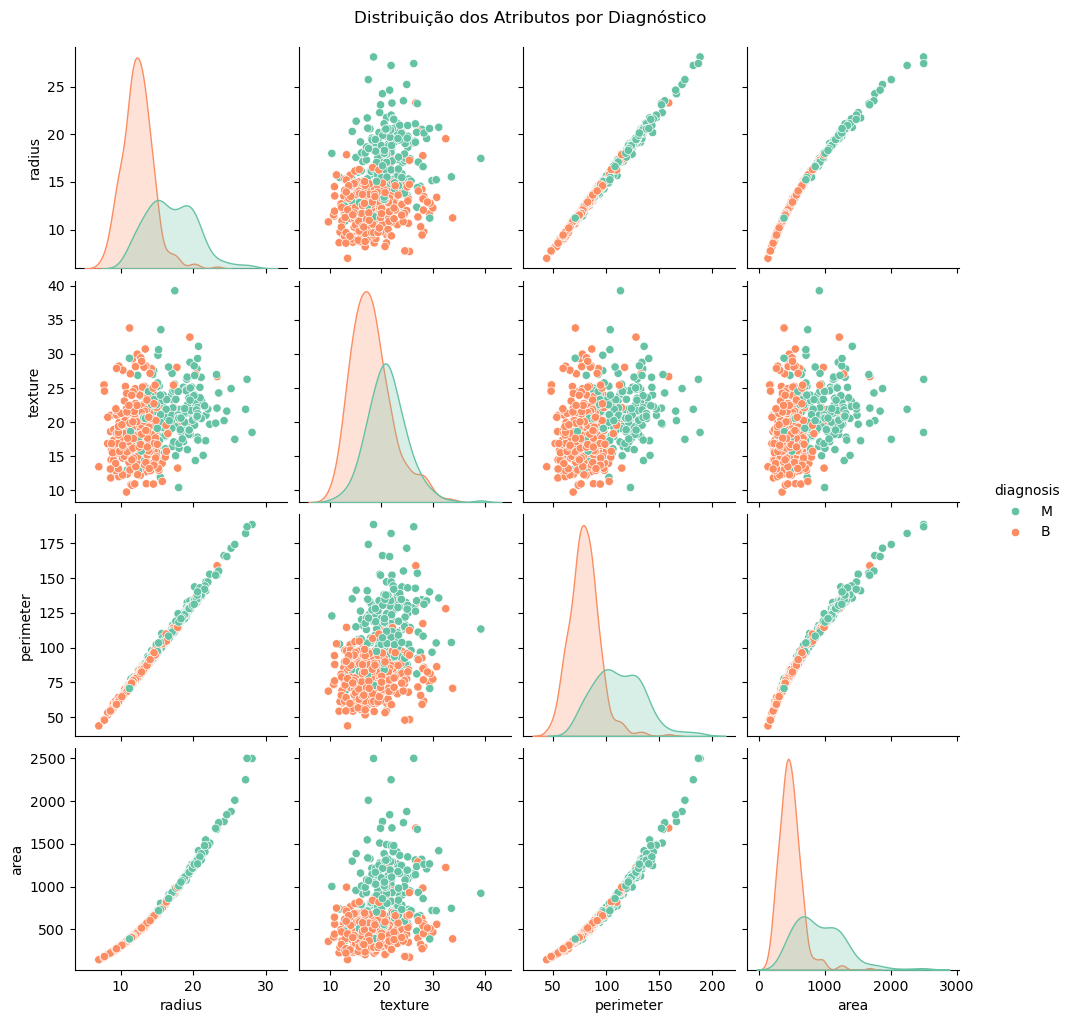

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotar a distribuição dos atributos por diagnóstico
sns.pairplot(data, hue='diagnosis', vars=['radius', 'texture', 'perimeter', 'area'], palette='Set2')
plt.suptitle("Distribuição dos Atributos por Diagnóstico", y=1.02)
plt.show()

### Divisão dos dados em treino e teste

In [7]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['laudo_cleaned'], data['diagnosis_encoded'], test_size=0.2, random_state=42
)

### Aquisição do modelo

In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "bert-base-uncased"

# Carregar o modelo pré-treinado para classificação
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Carregar o tokenizador
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Tokenizar dados

In [9]:
# Tokenizar os textos
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)

### Criar Datasets e Dataloaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# Convertendo encodings para tensores
train_inputs = torch.tensor(train_encodings['input_ids'])
train_attention_masks = torch.tensor(train_encodings['attention_mask'])
train_labels = torch.tensor(list(train_labels))

# Convertendo encodings para tensores
val_inputs = torch.tensor(val_encodings['input_ids'])
val_attention_masks = torch.tensor(val_encodings['attention_mask'])
val_labels = torch.tensor(list(val_labels))

# Criar TensorDatasets
train_dataset = TensorDataset(train_inputs, train_attention_masks, train_labels)
val_dataset = TensorDataset(val_inputs, val_attention_masks, val_labels)

# Criar DataLoaders
batch_size = 8

# Train DataLoader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

# Validation DataLoader
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)

### Otimizador e função de perda

In [11]:
# Definir o otimizador
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Definir a função de perda
criterion = torch.nn.CrossEntropyLoss()

### Treinamento do modelo

In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*Torch was not compiled with flash attention.*")

In [13]:
from tqdm import tqdm

# Definir o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Número de épocas
epochs = 3

for epoch in range(epochs):

    # Treinamento
    model.train()
    total_loss = 0

    # Iterar sobre os batches
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} - Training"):

        # Mover os tensores para o dispositivo
        batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)

        # Zerar os gradientes
        model.zero_grad()

        # Forward
        outputs = model(input_ids=batch_inputs, attention_mask=batch_masks, labels=batch_labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward e otimização
        loss.backward()
        optimizer.step()

        # Acumular a perda
        total_loss += loss.item()

    # Imprimir a perda média
    print(f"Epoch {epoch + 1} - Loss: {total_loss / len(train_dataloader)}")

    # Validação
    model.eval()
    total_correct = 0
    total_samples = 0

    # Desativar o cálculo dos gradientes
    with torch.no_grad():

        # Iterar sobre os batches
        for batch in tqdm(val_dataloader, desc="Validation"):

            # Mover os tensores para o dispositivo
            batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)

            # Forward
            outputs = model(input_ids=batch_inputs, attention_mask=batch_masks)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            # Calcular a acurácia
            total_correct += (predictions == batch_labels).sum().item()
            total_samples += batch_labels.size(0)

    # Imprimir a acurácia
    print(f"Epoch {epoch + 1} - Validation Accuracy: {total_correct / total_samples:.2f}")

Epoch 1 - Training: 100%|██████████| 57/57 [00:11<00:00,  5.01it/s]


Epoch 1 - Loss: 0.31908603404697616


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.58it/s]


Epoch 1 - Validation Accuracy: 0.96


Epoch 2 - Training: 100%|██████████| 57/57 [00:11<00:00,  5.10it/s]


Epoch 2 - Loss: 0.2683877881550998


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.59it/s]


Epoch 2 - Validation Accuracy: 0.96


Epoch 3 - Training: 100%|██████████| 57/57 [00:11<00:00,  5.08it/s]


Epoch 3 - Loss: 0.2717587217165713


Validation: 100%|██████████| 15/15 [00:00<00:00, 22.46it/s]

Epoch 3 - Validation Accuracy: 0.96


### Avaliação do modelo

In [14]:
y_test = []
y_pred = []
y_proba = []

# Modo de avaliação
model.eval()

# Desativar o cálculo dos gradientes
with torch.no_grad():

    # Iterar sobre os batches
    for batch in val_dataloader:

        # Mover os tensores para o dispositivo
        batch_inputs, batch_masks, batch_labels = tuple(b.to(device) for b in batch)

        # Forward
        outputs = model(input_ids=batch_inputs, attention_mask=batch_masks)
        logits = outputs.logits

        # Rótulos verdadeiros
        y_test.extend(batch_labels.cpu().numpy())

        # Previsões (classe com maior probabilidade)
        preds = torch.argmax(logits, dim=-1)
        y_pred.extend(preds.cpu().numpy())

        # Probabilidades da classe positiva
        y_proba.extend(torch.softmax(logits, dim=1)[:, 1].cpu().numpy())

#### Acurácia, Precisão, Recall e F1

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Acurácia
accuracy = accuracy_score(y_test, y_pred)

# Precisão
precision = precision_score(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred)

# F1 Score
f1 = f1_score(y_test, y_pred)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Acurácia: {accuracy:.2f}")
print(f"Precisão: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Acurácia: 0.96
Precisão: 0.98
Recall: 0.93
F1 Score: 0.95
ROC AUC: 0.94


#### Relatório de classificação

In [16]:
from sklearn.metrics import classification_report

# Relatório de classificação
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        69
           1       0.98      0.93      0.95        45

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



#### Matriz de confusão

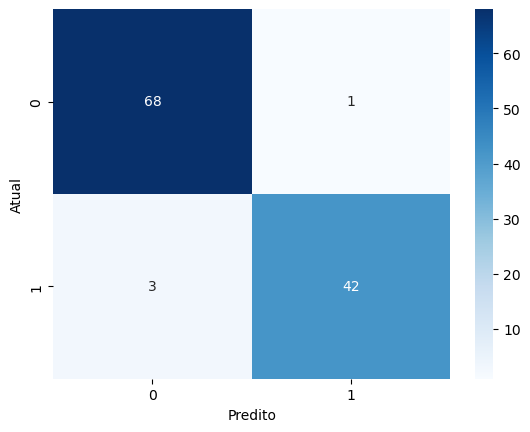

In [17]:
from sklearn.metrics import confusion_matrix

# Matriz de confusão
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito')
plt.ylabel('Atual')
plt.show()

#### Curva Precision-Recall

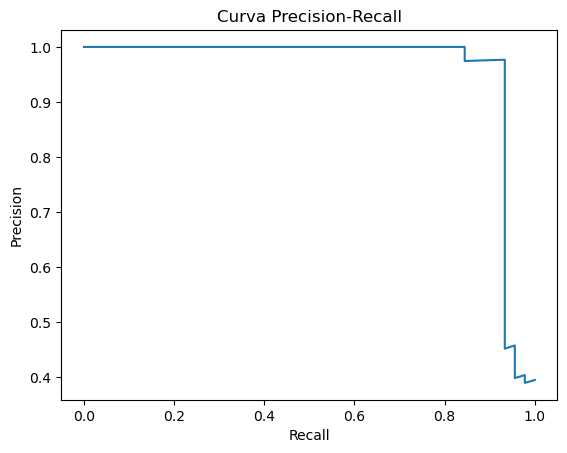

In [18]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.show()

#### Curva ROC

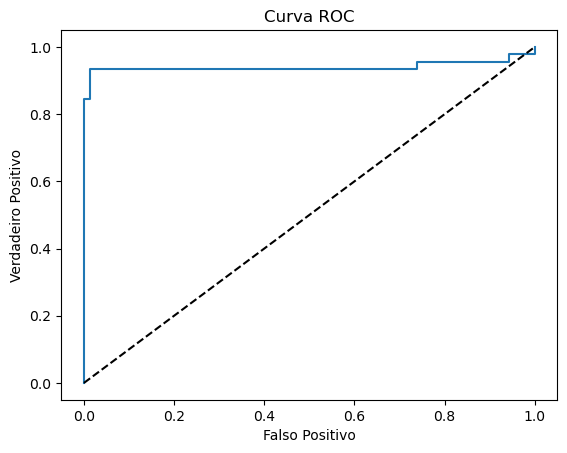

In [19]:
from sklearn.metrics import roc_curve

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC')
plt.show()

### Exemplo de uso

In [20]:
# Dados novos
new_texts = ["""
        Paciente: Luiza Moreira
        Exame: Mamografia
        Data do Exame: 2024-05-07

        Descrição:
        Observou-se uma lesão de aproximadamente 27.1 mm, localizada no quadrante inferior direito, com bordas regular.
        O exame sugere que a lesão apresenta características benigno.

        Conclusão: Benigno.
        Recomendação: Acompanhar evolução com novo exame em 6 meses.
             """,
        """
        Paciente: Clara Cardoso
        Exame: Mamografia
        Data do Exame: 2024-01-01

        Descrição:
        Observou-se uma lesão de aproximadamente 36.0 mm, localizada no quadrante inferior direito, com bordas regular.
        O exame sugere que a lesão apresenta características maligno.

        Conclusão: Maligno.
        Recomendação: Encaminhar para biópsia e avaliação oncológica.
        """]

# Tokenizar os novos textos
new_encodings = tokenizer(new_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

# Criar DataLoader
new_dataset = TensorDataset(new_encodings['input_ids'], new_encodings['attention_mask'])
new_dataloader = DataLoader(new_dataset, batch_size=1)

# Modo de avaliação
model.eval()

predictions = []

# Desativar o cálculo dos gradientes
with torch.no_grad():

    # Iterar sobre os batches
    for batch in new_dataloader:

        # Mover os tensores para o dispositivo
        batch_inputs, batch_masks = tuple(b.to(device) for b in batch)

        # Forward
        outputs = model(input_ids=batch_inputs, attention_mask=batch_masks)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        predictions.extend(preds.cpu().numpy())

# Imprimir as predições
print("Predições:", predictions)

Predições: [0, 1]
